#Model Implementation
##In this section, multiple models are developed, optimized, and evaluated. 
###The types of models include: 


*   Multi-Layer Perceptron (MLP) Neural Network
*   Support Vector Machine (SVM)
*   K-Nearest Neighbors (KNN)
*   Naïve Bayes






In [1]:
#Imports 
!pip install contractions
!pip install unidecode
!pip install keras-tuner
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import seaborn as sns
#from sklearn import classification_report
from tensorflow import keras
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from contractions import fix
import string
import regex as re
from sklearn.model_selection import train_test_split
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.compose import make_column_transformer
from sklearn import metrics
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 2.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.0 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

##Importing Data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#use if running in Google Colab and the dataset is in your Google Drive
read_data = pd.read_csv('/content/drive/MyDrive/Pre-processing/opinion_fact_news.csv')

#use if dataset is not in your google drive
#file_path = 'insert path to file here'
#read_data = pd.read_csv(file_path)

##Preprocessing 

In [4]:
#Removing stopwords and punctuation (with some exceptions), tokenizing, and lemmatizing text


punctuation = string.punctuation + "”“—’`"
stopwords_list = stopwords.words('english')
stopwords_list.extend(['reuters'])
stopwords_list = set([word for word in stopwords_list if word not in {'his', 
                                                                      'they', 
                                                                      'we', 
                                                                      'us', 
                                                                      'our', 
                                                                      'myself'
                                                                      }
                      ]
                     )



def clean_data(data):
    no_punct = re.sub(r"[^\w\s]|_", " ", data)
    token = word_tokenize(fix(no_punct))
    lemma = [WordNetLemmatizer().lemmatize(x) for x in token]
    stopwords_removed = [x.lower() for x in lemma if x.lower() not in stopwords_list]
    return stopwords_removed


#Encoding labels: 0=opinion 1=fact
data = read_data.copy()
data['label'] = np.where(data['label'] == 'opinion', 0, 1) 


#Seperating the data into X and Y variables
y_data = data['label'].copy() #this is the label column (target variable)
x_data = data.drop(['label'], axis=1) #this is title and body text

In [5]:
#Initial test train split

x_train, x_test, y_train, y_test,  = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

In [6]:
#Checking sizes


print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

x_train shape: (8000, 2)
y_train shape: (8000,)
x_test shape: (2000, 2)
y_test shape: (2000,)


## Transformation Pipeline
###BoW, ChiSq selection, and TFIDF transformation

In [7]:
#Assigning how many words we want to consider (these will be selected 
#top down from a list according to their 
#chi-squared value in descending order)
num_of_top_words = 200 


vectorizer = CountVectorizer(analyzer='word', lowercase=True, tokenizer=clean_data, stop_words=None, preprocessor=None)

tfidf_pipeline = Pipeline([
    ('tfidf/cleaning', make_column_transformer((vectorizer, 'title'), (vectorizer, 'body'))),
    ('chi2score-selection', SelectKBest(chi2, k=num_of_top_words)),
    ('tfidf-transformation', TfidfTransformer(use_idf=True))
])

x_train_tfidf = tfidf_pipeline.fit_transform(x_train, y_train)
x_test_tfidf = tfidf_pipeline.transform(x_test)

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Text(0.5, 0, 'Correlation Score between two features')

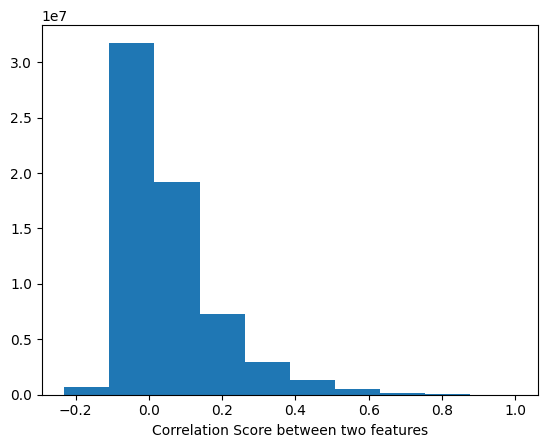

In [8]:
#For data analysis- quick look at correlations to ensure we can use Naive Bayes  
feature_names= tfidf_pipeline.get_feature_names_out()

new_x=x_train_tfidf.toarray()
corr_matrix=np.corrcoef(new_x)
a=np.concatenate(corr_matrix)

plt.hist(a)
plt.xlabel("Correlation Score between two features")

###Syntax
Use for models:



*  **x_train_tfidf** with **y_train**
*  **x_test_tfidf** with **y_test**



# MLP Neural Network

### Prelimenary Development

In [51]:
#Creating a simple prelimenary model 


model = keras.models.Sequential()
model.add(Dense(3, input_dim=num_of_top_words, activation='relu'))
model.add(Dropout(0.1))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss = "binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics = ["accuracy"])
history = model.fit(x_train_tfidf.toarray(), y_train, epochs=30, batch_size=50, validation_split = 0.2)


Epoch 1/30
128/128 [==============================] - 1s 4ms/step - loss: 0.5683 - accuracy: 0.8400 - val_loss: 0.4505 - val_accuracy: 0.9206
Epoch 2/30
128/128 [==============================] - 0s 2ms/step - loss: 0.3796 - accuracy: 0.9198 - val_loss: 0.3042 - val_accuracy: 0.9431
Epoch 3/30
128/128 [==============================] - 0s 2ms/step - loss: 0.2765 - accuracy: 0.9352 - val_loss: 0.2234 - val_accuracy: 0.9525
Epoch 4/30
128/128 [==============================] - 0s 2ms/step - loss: 0.2233 - accuracy: 0.9397 - val_loss: 0.1758 - val_accuracy: 0.9594
Epoch 5/30
128/128 [==============================] - 0s 3ms/step - loss: 0.1817 - accuracy: 0.9519 - val_loss: 0.1447 - val_accuracy: 0.9619
Epoch 6/30
128/128 [==============================] - 0s 2ms/step - loss: 0.1591 - accuracy: 0.9534 - val_loss: 0.1224 - val_accuracy: 0.9688
Epoch 7/30
128/128 [==============================] - 0s 2ms/step - loss: 0.1427 - accuracy: 0.9589 - val_loss: 0.1081 - val_accuracy: 0.9712
Epoch 

In [56]:
#Making predictions using test set (probabilities)
y_pred_proba_t = model.predict(x_test_tfidf.toarray())
print('MLP Predictions (Probabilities))\n: ', y_pred_proba_t)


#Transforming probability outputs into binary labels
pred_mlp_t = (model.predict(x_test_tfidf.toarray())> 0.5).astype("int32")

print('MLP Binary Predictions on Validation Data: \n', pred_mlp_t)

print('Prelimenary MLP Performance --> \n{}'.format(classification_report(y_test, pred_mlp_t)))

63/63 [==============================] - 0s 1ms/step
MLP Predictions (Probabilities))
:  [[5.2387547e-03]
 [9.9987739e-01]
 [2.4701116e-04]
 ...
 [9.9989516e-01]
 [9.8969096e-01]
 [9.9865240e-01]]
63/63 [==============================] - 0s 3ms/step
MLP Binary Predictions on Validation Data: 
 [[0]
 [1]
 [0]
 ...
 [1]
 [1]
 [1]]
Prelimenary MLP Performance --> 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1000
           1       0.99      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



###Hypertuning 

In [30]:
def model_builder(hp):
  '''
  Creates an archetecture that the hypermodel will be built according to
  '''
  # Initializing the sequential API and stacking the layers
  model = keras.Sequential()
  hp_nodes = hp.Int('nodes', min_value=1, max_value=5, step=1)
  hp_act = hp.Choice('activation', values=['sigmoid', 'softmax', 'relu'])
  model.add(Dense(hp_nodes, input_dim=num_of_top_words, activation=hp_act))
  hp_dr_rate = hp.Choice('dropout_rate', values=[0.1, 0.15, 0.2])
  model.add(Dropout(hp_dr_rate))
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.compile(loss = "binary_crossentropy", optimizer=keras.optimizers.Adam(), metrics = ["accuracy"])


  return model

In [31]:
#Instantiating the tuner


tuner = kt.Hyperband(hypermodel=model_builder, # the hypermodel
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3, 
                     directory='dir', # directory to save logs 
                     project_name='khyperband',
                     overwrite=True)



#Look at a summary of the tuner 
tuner.search_space_summary() 

Search space summary
Default search space size: 3
nodes (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid', 'softmax', 'relu'], 'ordered': False}
dropout_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.15, 0.2], 'ordered': True}


In [32]:
#To avoid unnecessary computation time
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#Perform hypertuning
tuner.search(x_train_tfidf.toarray(), y_train, epochs=30, validation_split=0.1, callbacks=[stop_early])

#Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=3)[0]

print(f"""
The hyperparameter search is complete. The optimal number of nodes in the first 
hidden layer is {best_hps.get('nodes')}, the optimal dropout rate for the dropout 
layer is {best_hps.get('dropout_rate')} and the best activation function for the 
hidden layer is {best_hps.get('activation')}.
""")

Trial 30 Complete [00h 00m 11s]
val_accuracy: 0.9599999785423279

Best val_accuracy So Far: 0.987500011920929
Total elapsed time: 00h 02m 08s

The hyperparameter search is complete. The optimal number of nodes in the first 
hidden layer is 5, the optimal dropout rate for the dropout 
layer is 0.1 and the best activation function for the 
hidden layer is relu.



In [36]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hps)
history = h_model.fit(x_train_tfidf.toarray(), y_train, epochs=30, batch_size=50, validation_split = 0.2)

Epoch 1/30
128/128 [==============================] - 3s 7ms/step - loss: 0.5794 - accuracy: 0.8378 - val_loss: 0.4413 - val_accuracy: 0.9494
Epoch 2/30
128/128 [==============================] - 1s 5ms/step - loss: 0.3433 - accuracy: 0.9458 - val_loss: 0.2535 - val_accuracy: 0.9538
Epoch 3/30
128/128 [==============================] - 1s 5ms/step - loss: 0.2199 - accuracy: 0.9516 - val_loss: 0.1738 - val_accuracy: 0.9594
Epoch 4/30
128/128 [==============================] - 1s 5ms/step - loss: 0.1679 - accuracy: 0.9527 - val_loss: 0.1340 - val_accuracy: 0.9656
Epoch 5/30
128/128 [==============================] - 1s 4ms/step - loss: 0.1358 - accuracy: 0.9594 - val_loss: 0.1097 - val_accuracy: 0.9694
Epoch 6/30
128/128 [==============================] - 1s 5ms/step - loss: 0.1137 - accuracy: 0.9653 - val_loss: 0.0937 - val_accuracy: 0.9750
Epoch 7/30
128/128 [==============================] - 1s 10ms/step - loss: 0.0987 - accuracy: 0.9697 - val_loss: 0.0826 - val_accuracy: 0.9762
Epoch

In [37]:
#Quick look at accuracy after hypertuning

#Testing accuracy
print('Testing Accuracy After Hypertuning: {}'.format(h_model.evaluate(x_test_tfidf.toarray(), y_test, return_dict=True)))


63/63 [==============================] - 0s 2ms/step - loss: 0.0395 - accuracy: 0.9865
Testing Accuracy After Hypertuning: {'loss': 0.039456646889448166, 'accuracy': 0.9865000247955322}


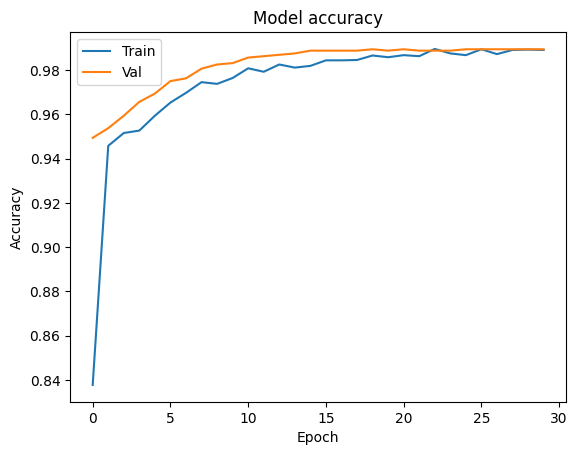

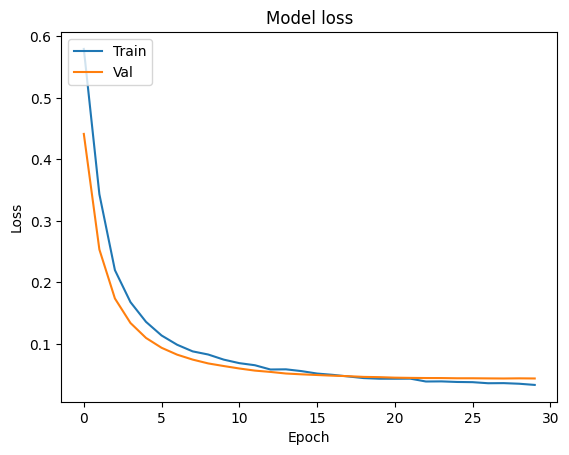

In [38]:
#Plotting loss and accuracy over ephochs 


#Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [57]:
#MLP Predictions 

#Making predictions using hold-out set (probabilities)
y_pred_proba_t = h_model.predict(x_test_tfidf.toarray())
print('MLP Predictions (Probabilities))\n: ', y_pred_proba_t)


#Transforming probability outputs into binary labels
pred_mlp_t = (h_model.predict(x_test_tfidf.toarray())> 0.5).astype("int32")
print('MLP Binary Predictions on Validation Data: \n', pred_mlp_t)

print('Prelimenary MLP Performance --> \n {}'.format(classification_report(y_test, pred_mlp_t)))

63/63 [==============================] - 0s 1ms/step
MLP Predictions (Probabilities))
:  [[4.9569388e-03]
 [9.9999970e-01]
 [7.1647129e-04]
 ...
 [9.9999994e-01]
 [9.9791467e-01]
 [9.9998057e-01]]
63/63 [==============================] - 0s 1ms/step
MLP Binary Predictions on Validation Data: 
 [[0]
 [1]
 [0]
 ...
 [1]
 [1]
 [1]]
Prelimenary MLP Performance --> 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1000
           1       0.99      0.98      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



# SVM, KNN and Naive Bayes Models 

### Prelimenary Development

In [46]:
#SVM 


#Initialising the parameters for prelimenary SVM model
svm_p = svm.SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')

#Fitting the model on transformed training dataset
svm_p.fit(x_train_tfidf, y_train)

#Obtaining prediction on transformed test dataset
pred_svm = svm_p.predict(x_test_tfidf)
print("Prelimenary SVM Performance -> \n", classification_report(y_test, pred_svm))

Prelimenary SVM Performance -> 
               precision    recall  f1-score   support

           0       0.92      0.99      0.95      1000
           1       0.99      0.91      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [58]:
#KNN


#Initialising the parameters for prelimenary KNN model
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', leaf_size=30)

#Fitting the model on transformed training dataset
knn.fit(x_train_tfidf, y_train)

#Obtaining prediction on transformed test dataset
pred_knn = knn.predict(x_test_tfidf)
print("Prelimenary KNN Performance ->\n ", classification_report(y_test, pred_knn))

Prelimenary KNN Performance ->
                precision    recall  f1-score   support

           0       0.96      0.96      0.96      1000
           1       0.96      0.96      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [59]:
#Naive Bayes


#Initialising the parameters for prelimenary Naive Bayes model
nb = MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

#Fitting the model on transformed training dataset
nb.fit(x_train_tfidf, y_train)

#Obtaining prediction on transformed test dataset
pred_nb = nb.predict(x_test_tfidf)
print("Prelimenary NB Performance -> \n", classification_report(y_test, pred_nb))

Prelimenary NB Performance -> 
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      1000
           1       0.99      0.90      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.95      0.94      0.94      2000
weighted avg       0.95      0.94      0.94      2000



##Hypertuning 


In [60]:
#Making search spaces


svm_param_space = {'kernel': ['linear', 'rbf'], 
                   'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10], 
                   'degree':[1,2,3,4,5]
                   }

knn_param_space = {'n_neighbors': [3, 5, 7, 9, 11], 
                   'weights': ['uniform', 'distance'], 
                   'leaf_size':[5, 10, 30, 60, 90]
                   }

nb_param_space = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0], 
                  'fit_prior': [True, False]
                  }

In [61]:
#Building RandomSearchCV


cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scoring = 'roc_auc'


svm_rand_search = RandomizedSearchCV(svm_p, 
                                     svm_param_space,
                                     scoring=scoring,
                                     n_jobs=-1,
                                     cv=cv)

knn_rand_search = RandomizedSearchCV(knn,
                                     knn_param_space,
                                     scoring=scoring, 
                                     n_jobs=-1,
                                     cv=cv)

nb_rand_search = RandomizedSearchCV(nb,
                                    nb_param_space,
                                    scoring=scoring,
                                    n_jobs=-1,
                                    cv=cv)


In [62]:
#Running RandomSearchCV on all models

rands = [svm_rand_search, 
        knn_rand_search,
        nb_rand_search]

for rand in rands:
  rand.fit(x_train_tfidf, y_train)  

In [63]:
#Identifying best parameters for each model

grid_dict = {0: 'SVM', 1: 'KNN', 2: 'NB'}
             
for i, model in enumerate(rands):
  print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

SVM Best Params: {'kernel': 'rbf', 'gamma': 0.1, 'degree': 1, 'C': 10}
KNN Best Params: {'weights': 'distance', 'n_neighbors': 11, 'leaf_size': 90}
NB Best Params: {'fit_prior': True, 'alpha': 0.1}


In [65]:
#Making optimal models and using them to predict on test data


#SVM 
svm_op = svm.SVC(C=10, kernel='rbf', gamma=0.1, degree=1)
svm_op.fit(x_train_tfidf, y_train)
pred_svm_t = svm_op.predict(x_test_tfidf)
print("SVM Accuracy Score After Hypertuning -> ", accuracy_score(y_test, pred_svm)*100)

#KNN
knn_op = KNeighborsClassifier(n_neighbors=11, weights='distance', leaf_size=90)
knn_op.fit(x_train_tfidf, y_train)
pred_knn_t = knn_op.predict(x_test_tfidf)
print("KNN Accuracy Score After Hypertuning-> ", accuracy_score(y_test, pred_knn)*100)

#NB
nb_op = MultinomialNB(alpha=0.1, fit_prior=True, class_prior=None)
nb_op.fit(x_train_tfidf, y_train)
pred_nb_t = nb_op.predict(x_test_tfidf)
print("NB Accuracy Score After Hypertuning -> ", accuracy_score(y_test, pred_nb)*100)

SVM Accuracy Score After Hypertuning ->  95.15
KNN Accuracy Score After Hypertuning->  96.0
NB Accuracy Score After Hypertuning ->  94.39999999999999


#Evaluation

##Evaluating performance on test data 

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96      1000
           1       0.97      0.95      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

Classification Report for NB:
               precision    recall  f1-score   support

           0       0.91      0.99      0.95      1000
           1       0.99      0.91      0.94      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95

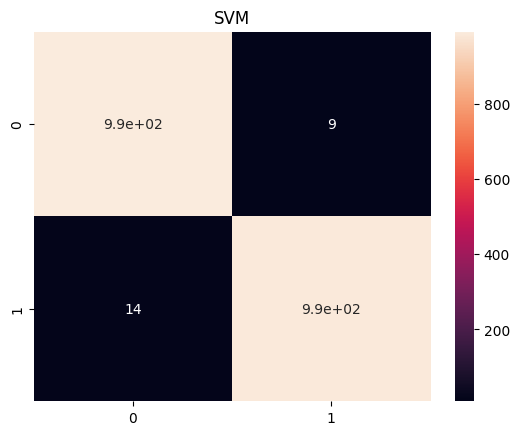

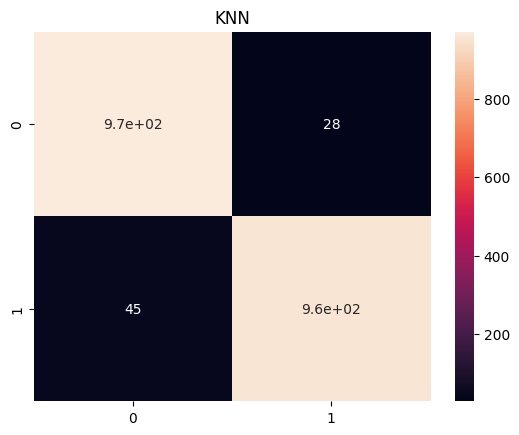

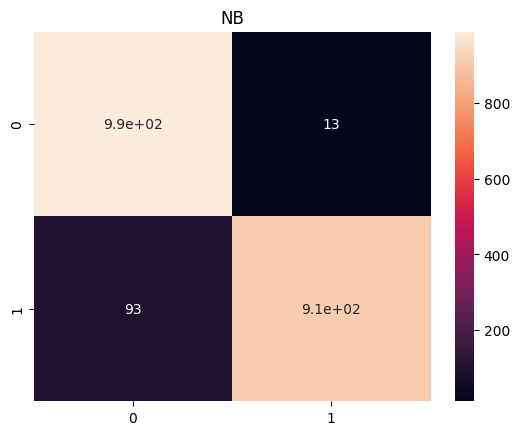

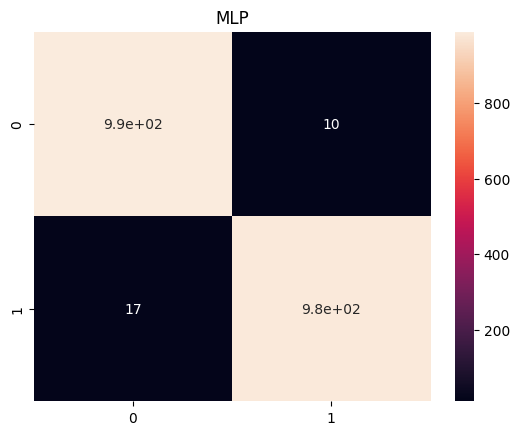

In [66]:
#Confusion matricies and classification reports for each model (Testing Data)


models = ['SVM', 'KNN', 'NB', 'MLP']
preds = [pred_svm_t, pred_knn_t, pred_nb_t, pred_mlp_t]
num = [1,2,3,4]


for i, pred, mod in zip(num, preds, models):
  #Classification Reports
  print('Classification Report for {}:\n'.format(mod),  classification_report(y_test, pred))

  #Confusion Matricies
  cf_matrix = confusion_matrix(y_test, pred)
  plt.figure(i)
  sns.heatmap(cf_matrix, annot=True).set(title='{}'.format(mod))


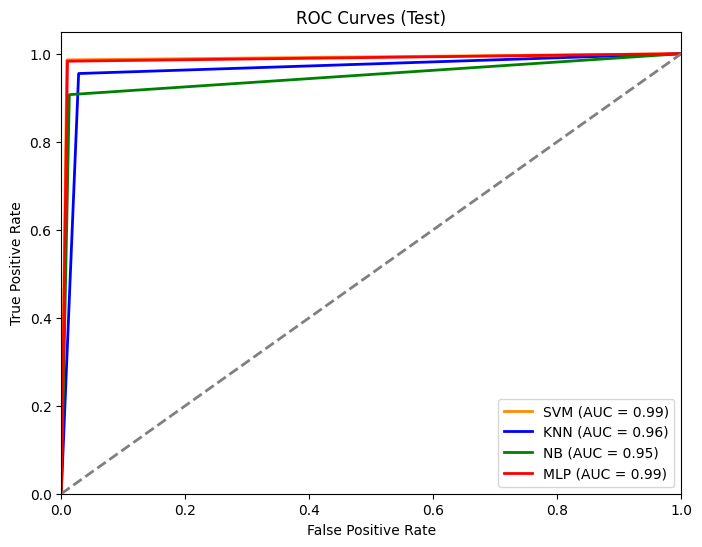

In [67]:
#ROC curves (Testing Data)


#Calculating ROC Scores
svm_auc_score = roc_auc_score(y_test, pred_svm_t)
knn_auc_score = roc_auc_score(y_test, pred_knn_t)
nb_auc_score = roc_auc_score(y_test, pred_nb_t)
mlp_auc_score = roc_auc_score(y_test, pred_mlp_t)

#Finding false pos and true pos rates
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_test,  pred_svm_t)
fpr_knn, tpr_knn, _ = metrics.roc_curve(y_test,  pred_knn_t)
fpr_nb, tpr_nb, _ = metrics.roc_curve(y_test,  pred_nb_t)
fpr_mlp, tpr_mlp, _ = metrics.roc_curve(y_test,  pred_mlp_t)

#Plotting all ROC data onto one graph
# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='SVM (AUC = %0.2f)' % svm_auc_score)
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label='KNN (AUC = %0.2f)' % knn_auc_score)
plt.plot(fpr_nb, tpr_nb, color='green', lw=2, label='NB (AUC = %0.2f)' % nb_auc_score)
plt.plot(fpr_mlp, tpr_mlp, color='red', lw=2, label='MLP (AUC = %0.2f)' % mlp_auc_score)

# Set plot properties
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Test)')
plt.legend(loc="lower right")

plt.show()


# Testing on external data

Here is a link to the dataset used https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

In [ ]:
#Loading and preprocessing external data 


# Reading in dataset
other_data = pd.read_csv('/content/drive/MyDrive/Pre-processing/WELFake_Dataset.csv')

# Removing NaN values
other_data.dropna(inplace=True)

# Removing redundant columns and renaming columns to be in format suited for our 
#models
other_data = other_data.drop(['Unnamed: 0'], axis=1)
other_data = other_data.rename(columns={"text": "body"})


data = other_data.copy()

#Seperating the data into X and Y variables
y_test = data['label'].copy() #this is the label column (target variable)
x_data = data.drop(['label'], axis=1) #this is title and body text



#only creating a "test" tdidf because the whole dataset is being used as a test, no training.
#here we are using third party external data to test our models

x_test_tfidf = tfidf_pipeline.transform(x_data)

In [ ]:
#Making predictions on test data 


pred_svm_t = svm_op.predict(x_test_tfidf)
pred_knn_t = knn_op.predict(x_test_tfidf)
pred_nb_t = nb_op.predict(x_test_tfidf)
pred_mlp_t = (h_model.predict(x_test_tfidf.toarray())> 0.5).astype("int32")

In [ ]:
#Confusion matricies and classification reports for each model (Testing Data)


models = ['SVM', 'KNN', 'NB', 'MLP']
preds = [pred_svm_t, pred_knn_t, pred_nb_t, pred_mlp_t]
num = [1,2,3,4]


for i, pred, mod in zip(num, preds, models):
  #Classification Reports
  print('Classification Report for {} (Test):\n'.format(mod),  classification_report(y_test, pred))

  #Confusion Matricies
  cf_matrix = confusion_matrix(y_test, pred)
  plt.figure(i)
  sns.heatmap(cf_matrix, annot=True).set(title='{} (Test)'.format(mod))

In [ ]:
#ROC curves (Testing Data)


#Calculating ROC Scores
svm_auc_score = roc_auc_score(y_test, pred_svm_t)
knn_auc_score = roc_auc_score(y_test, pred_knn_t)
nb_auc_score = roc_auc_score(y_test, pred_nb_t)
mlp_auc_score = roc_auc_score(y_test, pred_mlp_t)

#Finding false pos and true pos rates
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_test,  pred_svm_t)
fpr_knn, tpr_knn, _ = metrics.roc_curve(y_test,  pred_knn_t)
fpr_nb, tpr_nb, _ = metrics.roc_curve(y_test,  pred_nb_t)
fpr_mlp, tpr_mlp, _ = metrics.roc_curve(y_test,  pred_mlp_t)

#Plotting all ROC data onto one graph
# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='SVM (AUC = %0.2f)' % svm_auc_score)
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label='KNN (AUC = %0.2f)' % knn_auc_score)
plt.plot(fpr_nb, tpr_nb, color='green', lw=2, label='NB (AUC = %0.2f)' % nb_auc_score)
plt.plot(fpr_mlp, tpr_mlp, color='red', lw=2, label='MLP (AUC = %0.2f)' % mlp_auc_score)

# Set plot properties
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Test)')
plt.legend(loc="lower right")

plt.show()

*The reasons as to why our model works so well on the dataset we were assigned and poorly on general data will be explored and discussed in the report.*
